# Search chemicals by annealing (one-component system)

## Summary
1. Load database
    - Load chemical structures (SMILES) and their properties
- Converting chemical structures to binary arrays
    - Fingerprints are used
    - Less important values will be removed by compression
    - Interaction terms xixj will be added
- Regression by a linear model
    - Use SGD to save time
- Prepare QUBO
    - Add perturbation if necessary
- Find best binary by annealer
- Compare the binary with the database
    - Extract chemicasl with higher similarity
- Generate chemicals directly from the found binary


In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem, Draw
from rdkit import Chem
import matplotlib.pyplot as plt
import sys

sys.path.append("../lib/bit")
sys.path.append("../lib/chem")
sys.path.append("../lib/prediction")
sys.path.append("../lib/annealing")


# Load database

In [2]:
#load compound files

#slect files you like

mode=0

if mode ==0:
    #melting point
    file_path="database/BradleyDoublePlusGoodMeltingPointDataset.csv"
    target_param_name="mpC"
    smiles_column="smiles"
    
elif mode==1:
    #solubility param
    file_path="database/delaney.csv"
    target_param_name="measured log(solubility:mol/L)"
    smiles_column="SMILES"
    
elif mode==2:
    #glass transition temperature
    file_path="database/Polymer.csv"
    target_param_name="Glass transition temperature"
    smiles_column="SMILES"

elif mode==3:
    #solar cell
    file_path="database/solarcell.csv"
    target_param_name="PCE_max(%)"
    smiles_column="SMILES"

df=pd.read_csv(file_path)
df=df[[smiles_column,target_param_name]]
df=df.dropna()

print("mode: ", file_path)

mode:  database/BradleyDoublePlusGoodMeltingPointDataset.csv


In [3]:
#run this code if you want to explore minimum values (e.g., low melting point)
#df[target_param_name]=-df[target_param_name]

print(df.shape)
df[:5]

(3041, 2)


,smiles,mpC
0,C1(CCC1)C,-161.51
1,[O-][N+]#N,-90.80
2,FS(F)(=O)=O,-135.80
3,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80
4,BrBr,-7.20


In [4]:
#init fingerprint class
from Fingerprint import Fingerprint

FP=Fingerprint()
FP.fpFunc=Chem.RDKFingerprint  #other fingerprint function of rdkit can be used if necessary

# Prepare dataset x,y
## Convert chemicals to binary (ex: CC1=CC=CC=C1) to (0,1,1,1,0,1,1,0,1...) = $ (x_1,x_2, ....,x_N, x_1x_2,x_1x_3,....) $
1. Remove molecules which cannot be calculated by rdkit
- Split into train and test (train_df, test_df)
    - Ratio of 0.9 / 0.1
    - 5-Hold cross validation is also conducted in the paper
- Calculate binaries
    - First, prepare train dataset (fit_transform)
        - 1) Calculate 2048-dimensional fingerprints
        - 2) Compress them into n-dimensional arrays
            -  you can change the compression threshold
        - 3) Add interactions ｘ=(x1, x2, x3, ...,xN, x1x2, x1x3, ...)
    - Then, prepare test dataset (transform)
- Calculate z-scores of the target parameter

In [5]:
from PredictionUtil import split_dataframe
from SMILESConverter import SMILESConverter
from sklearn.preprocessing import StandardScaler

#change threshold for compresshon
#the desired dimension would be around 100-500.
#To large dimension will consume very large time and memory
threshold=0.5

#1. delete inappropriate SMILES
_,available_index=FP.calc_fingerprint(df[smiles_column].values)
df=df[available_index]

#2. split data
train_df,test_df=split_dataframe(df,0.1)

#3. prepare X
print("compressing")
smiles_converter=SMILESConverter(FP,threshold=threshold)
%time x_train=smiles_converter.fit_transform(train_df[smiles_column])
x_test=smiles_converter.transform(test_df[smiles_column])

#4. prepare Y
print("standardizing")
sc=StandardScaler()
y_train=sc.fit_transform(np.array(train_df[target_param_name].values).reshape(-1,1))
y_test=sc.transform(np.array(test_df[target_param_name].values).reshape(-1,1))
print("done")


error  c1cccn1
error  N#Cc3cncc3c1cccc2OC(F)(F)Oc12
error  COc1cc(cc(OC)c1OC)/C=C/C(=O)O[C@@H]3C[C@@H]4CN5CCc2c6ccc(OC)cc6nc2[C@H]5C[C@@H]4[C@@H]([C@H]3OC)C(=O)OC
error  c1cncn1
error  c1cccc2nccc12
error  Cc1cc2nnnc2cc1
error  O=C(OC)[C@@]2(C[C@H]4C[C@@](O)(CC)C[N@@](CCc1c3ccccc3nc12)C4)c5cc9c(cc5OC)N(C=O)[C@@H]6[C@]98CCN7CC=C[C@@](CC)([C@@H](OC(C)=O)[C@]6(O)C(=O)OC)[C@H]78
error  [O-][N+](=O)c1ccc2ncnc2c1
error  [O-][N+](=O)c1cnc(C)n1
error  c1cccc2ncnc12
error  Cc2cnc1ccccc12
error  c1cccc2nnnc12
error  n2cnc(NCc1ccccc1)c3ncnc23
error  n1c3ccccc3nc1c2cscn2
error  N[C@@H](Cc1cncn1)C(=O)O
error  Sc1nc2ccccc2n1
compressing
extracted  77 bits from 2048  bits
Wall time: 4.64 s
standardizing
done


# Regression
## $y = \sum_{i\neq j}J_{ij} x_ix_j\ +  \sum_{i=1}h_ix_i \$
- Ridge model is used
- SGD is used to reduce regression time
- This would take a long time

In [6]:
from SGDModel import get_model

model=get_model(x_train,y_train)

-- Epoch 1
Norm: 0.29, NNZs: 3003, Bias: -0.077541, T: 2450, Avg. loss: 0.300213
Total training time: 0.02 seconds.
-- Epoch 2

C:\Users\kan\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Norm: 0.37, NNZs: 3003, Bias: -0.104249, T: 4900, Avg. loss: 0.245767
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 3003, Bias: -0.126772, T: 7350, Avg. loss: 0.229122
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 0.44, NNZs: 3003, Bias: -0.141194, T: 9800, Avg. loss: 0.221793
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 3003, Bias: -0.154344, T: 12250, Avg. loss: 0.215715
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 3003, Bias: -0.167784, T: 14700, Avg. loss: 0.211341
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 0.51, NNZs: 3003, Bias: -0.180517, T: 17150, Avg. loss: 0.206698
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 0.52, NNZs: 3003, Bias: -0.190055, T: 19600, Avg. loss: 0.205606
Total training time: 0.33 seconds.
-- Epoch 9
Norm: 0.54, NNZs: 3003, Bias: -0.200981, T: 22050, Avg. loss: 0.203096
Total training time: 0.36 seconds.
-- Epoch 10
Norm: 0.55, NNZs: 3003, Bias: -0.209926, T: 24500, Avg. loss: 0.2

Norm: 0.73, NNZs: 3003, Bias: -0.496579, T: 181300, Avg. loss: 0.173928
Total training time: 3.29 seconds.
-- Epoch 75
Norm: 0.73, NNZs: 3003, Bias: -0.498905, T: 183750, Avg. loss: 0.172730
Total training time: 3.33 seconds.
-- Epoch 76
Norm: 0.73, NNZs: 3003, Bias: -0.502427, T: 186200, Avg. loss: 0.172654
Total training time: 3.38 seconds.
-- Epoch 77
Norm: 0.73, NNZs: 3003, Bias: -0.504481, T: 188650, Avg. loss: 0.173323
Total training time: 3.42 seconds.
-- Epoch 78
Norm: 0.73, NNZs: 3003, Bias: -0.506926, T: 191100, Avg. loss: 0.172634
Total training time: 3.46 seconds.
-- Epoch 79
Norm: 0.73, NNZs: 3003, Bias: -0.509328, T: 193550, Avg. loss: 0.171735
Total training time: 3.51 seconds.
-- Epoch 80
Norm: 0.73, NNZs: 3003, Bias: -0.511913, T: 196000, Avg. loss: 0.173079
Total training time: 3.55 seconds.
-- Epoch 81
Norm: 0.73, NNZs: 3003, Bias: -0.514731, T: 198450, Avg. loss: 0.172778
Total training time: 3.60 seconds.
-- Epoch 82
Norm: 0.73, NNZs: 3003, Bias: -0.516313, T: 2009

-- Epoch 145
Norm: 0.74, NNZs: 3003, Bias: -0.628187, T: 355250, Avg. loss: 0.169808
Total training time: 6.50 seconds.
-- Epoch 146
Norm: 0.74, NNZs: 3003, Bias: -0.629842, T: 357700, Avg. loss: 0.169854
Total training time: 6.55 seconds.
-- Epoch 147
Norm: 0.74, NNZs: 3003, Bias: -0.631097, T: 360150, Avg. loss: 0.169637
Total training time: 6.58 seconds.
-- Epoch 148
Norm: 0.74, NNZs: 3003, Bias: -0.632396, T: 362600, Avg. loss: 0.169680
Total training time: 6.62 seconds.
-- Epoch 149
Norm: 0.74, NNZs: 3003, Bias: -0.634035, T: 365050, Avg. loss: 0.169086
Total training time: 6.67 seconds.
-- Epoch 150
Norm: 0.74, NNZs: 3003, Bias: -0.635157, T: 367500, Avg. loss: 0.169068
Total training time: 6.71 seconds.
-- Epoch 151
Norm: 0.74, NNZs: 3003, Bias: -0.636198, T: 369950, Avg. loss: 0.169613
Total training time: 6.75 seconds.
-- Epoch 152
Norm: 0.74, NNZs: 3003, Bias: -0.637287, T: 372400, Avg. loss: 0.169494
Total training time: 6.79 seconds.
-- Epoch 153
Norm: 0.74, NNZs: 3003, Bia

-- Epoch 215
Norm: 0.75, NNZs: 3003, Bias: -0.699089, T: 526750, Avg. loss: 0.167726
Total training time: 9.60 seconds.
-- Epoch 216
Norm: 0.75, NNZs: 3003, Bias: -0.699811, T: 529200, Avg. loss: 0.168301
Total training time: 9.64 seconds.
-- Epoch 217
Norm: 0.75, NNZs: 3003, Bias: -0.700678, T: 531650, Avg. loss: 0.168666
Total training time: 9.68 seconds.
-- Epoch 218
Norm: 0.75, NNZs: 3003, Bias: -0.702046, T: 534100, Avg. loss: 0.168327
Total training time: 9.72 seconds.
-- Epoch 219
Norm: 0.75, NNZs: 3003, Bias: -0.702369, T: 536550, Avg. loss: 0.168378
Total training time: 9.76 seconds.
-- Epoch 220
Norm: 0.75, NNZs: 3003, Bias: -0.702867, T: 539000, Avg. loss: 0.168869
Total training time: 9.81 seconds.
-- Epoch 221
Norm: 0.75, NNZs: 3003, Bias: -0.704094, T: 541450, Avg. loss: 0.168129
Total training time: 9.85 seconds.
-- Epoch 222
Norm: 0.75, NNZs: 3003, Bias: -0.704512, T: 543900, Avg. loss: 0.168399
Total training time: 9.90 seconds.
-- Epoch 223
Norm: 0.75, NNZs: 3003, Bia

Norm: 0.75, NNZs: 3003, Bias: -0.741408, T: 693350, Avg. loss: 0.168483
Total training time: 12.58 seconds.
-- Epoch 284
Norm: 0.75, NNZs: 3003, Bias: -0.741925, T: 695800, Avg. loss: 0.167992
Total training time: 12.61 seconds.
-- Epoch 285
Norm: 0.75, NNZs: 3003, Bias: -0.742609, T: 698250, Avg. loss: 0.167734
Total training time: 12.65 seconds.
-- Epoch 286
Norm: 0.75, NNZs: 3003, Bias: -0.742338, T: 700700, Avg. loss: 0.167898
Total training time: 12.69 seconds.
-- Epoch 287
Norm: 0.75, NNZs: 3003, Bias: -0.743406, T: 703150, Avg. loss: 0.167395
Total training time: 12.74 seconds.
-- Epoch 288
Norm: 0.75, NNZs: 3003, Bias: -0.743446, T: 705600, Avg. loss: 0.168465
Total training time: 12.78 seconds.
-- Epoch 289
Norm: 0.75, NNZs: 3003, Bias: -0.744043, T: 708050, Avg. loss: 0.168007
Total training time: 12.83 seconds.
-- Epoch 290
Norm: 0.75, NNZs: 3003, Bias: -0.744566, T: 710500, Avg. loss: 0.168231
Total training time: 12.88 seconds.
-- Epoch 291
Norm: 0.75, NNZs: 3003, Bias: -0

-- Epoch 356
Norm: 0.75, NNZs: 3003, Bias: -0.769642, T: 872200, Avg. loss: 0.167242
Total training time: 15.85 seconds.
-- Epoch 357
Norm: 0.75, NNZs: 3003, Bias: -0.770672, T: 874650, Avg. loss: 0.167258
Total training time: 15.89 seconds.
-- Epoch 358
Norm: 0.75, NNZs: 3003, Bias: -0.770944, T: 877100, Avg. loss: 0.167118
Total training time: 15.94 seconds.
-- Epoch 359
Norm: 0.75, NNZs: 3003, Bias: -0.771124, T: 879550, Avg. loss: 0.167070
Total training time: 15.98 seconds.
-- Epoch 360
Norm: 0.75, NNZs: 3003, Bias: -0.771415, T: 882000, Avg. loss: 0.166976
Total training time: 16.02 seconds.
-- Epoch 361
Norm: 0.75, NNZs: 3003, Bias: -0.771697, T: 884450, Avg. loss: 0.167857
Total training time: 16.07 seconds.
-- Epoch 362
Norm: 0.75, NNZs: 3003, Bias: -0.771538, T: 886900, Avg. loss: 0.167882
Total training time: 16.11 seconds.
-- Epoch 363
Norm: 0.75, NNZs: 3003, Bias: -0.772064, T: 889350, Avg. loss: 0.167208
Total training time: 16.16 seconds.
-- Epoch 364
Norm: 0.75, NNZs: 3

Norm: 0.75, NNZs: 3003, Bias: -0.788101, T: 1046150, Avg. loss: 0.166923
Total training time: 19.06 seconds.
-- Epoch 428
Norm: 0.75, NNZs: 3003, Bias: -0.788350, T: 1048600, Avg. loss: 0.166890
Total training time: 19.11 seconds.
-- Epoch 429
Norm: 0.75, NNZs: 3003, Bias: -0.788707, T: 1051050, Avg. loss: 0.167168
Total training time: 19.15 seconds.
-- Epoch 430
Norm: 0.75, NNZs: 3003, Bias: -0.788743, T: 1053500, Avg. loss: 0.167268
Total training time: 19.19 seconds.
-- Epoch 431
Norm: 0.75, NNZs: 3003, Bias: -0.789119, T: 1055950, Avg. loss: 0.167365
Total training time: 19.24 seconds.
-- Epoch 432
Norm: 0.75, NNZs: 3003, Bias: -0.789355, T: 1058400, Avg. loss: 0.167650
Total training time: 19.28 seconds.
-- Epoch 433
Norm: 0.75, NNZs: 3003, Bias: -0.789225, T: 1060850, Avg. loss: 0.167057
Total training time: 19.32 seconds.
-- Epoch 434
Norm: 0.75, NNZs: 3003, Bias: -0.789506, T: 1063300, Avg. loss: 0.167602
Total training time: 19.37 seconds.
-- Epoch 435
Norm: 0.75, NNZs: 3003, 

-- Epoch 495
Norm: 0.75, NNZs: 3003, Bias: -0.800007, T: 1212750, Avg. loss: 0.167564
Total training time: 22.14 seconds.
-- Epoch 496
Norm: 0.75, NNZs: 3003, Bias: -0.799886, T: 1215200, Avg. loss: 0.167387
Total training time: 22.19 seconds.
-- Epoch 497
Norm: 0.75, NNZs: 3003, Bias: -0.800089, T: 1217650, Avg. loss: 0.167267
Total training time: 22.23 seconds.
-- Epoch 498
Norm: 0.75, NNZs: 3003, Bias: -0.800341, T: 1220100, Avg. loss: 0.167413
Total training time: 22.27 seconds.
-- Epoch 499
Norm: 0.75, NNZs: 3003, Bias: -0.800443, T: 1222550, Avg. loss: 0.167206
Total training time: 22.31 seconds.
-- Epoch 500
Norm: 0.75, NNZs: 3003, Bias: -0.800817, T: 1225000, Avg. loss: 0.167554
Total training time: 22.36 seconds.
-- Epoch 501
Norm: 0.75, NNZs: 3003, Bias: -0.800864, T: 1227450, Avg. loss: 0.167281
Total training time: 22.40 seconds.
-- Epoch 502
Norm: 0.75, NNZs: 3003, Bias: -0.800973, T: 1229900, Avg. loss: 0.167625
Total training time: 22.45 seconds.
-- Epoch 503
Norm: 0.75,

Norm: 0.75, NNZs: 3003, Bias: -0.808261, T: 1381800, Avg. loss: 0.166947
Total training time: 25.26 seconds.
-- Epoch 565
Norm: 0.75, NNZs: 3003, Bias: -0.808008, T: 1384250, Avg. loss: 0.167383
Total training time: 25.30 seconds.
-- Epoch 566
Norm: 0.75, NNZs: 3003, Bias: -0.808132, T: 1386700, Avg. loss: 0.167053
Total training time: 25.35 seconds.
-- Epoch 567
Norm: 0.75, NNZs: 3003, Bias: -0.808506, T: 1389150, Avg. loss: 0.167356
Total training time: 25.39 seconds.
-- Epoch 568
Norm: 0.75, NNZs: 3003, Bias: -0.808425, T: 1391600, Avg. loss: 0.167334
Total training time: 25.44 seconds.
-- Epoch 569
Norm: 0.75, NNZs: 3003, Bias: -0.808710, T: 1394050, Avg. loss: 0.167418
Total training time: 25.49 seconds.
-- Epoch 570
Norm: 0.75, NNZs: 3003, Bias: -0.808604, T: 1396500, Avg. loss: 0.166352
Total training time: 25.53 seconds.
-- Epoch 571
Norm: 0.75, NNZs: 3003, Bias: -0.808933, T: 1398950, Avg. loss: 0.167304
Total training time: 25.57 seconds.
-- Epoch 572
Norm: 0.75, NNZs: 3003, 

Norm: 0.75, NNZs: 3003, Bias: -0.813971, T: 1553300, Avg. loss: 0.167011
Total training time: 28.49 seconds.
-- Epoch 635
Norm: 0.75, NNZs: 3003, Bias: -0.814272, T: 1555750, Avg. loss: 0.166775
Total training time: 28.54 seconds.
-- Epoch 636
Norm: 0.75, NNZs: 3003, Bias: -0.814173, T: 1558200, Avg. loss: 0.166971
Total training time: 28.59 seconds.
-- Epoch 637
Norm: 0.75, NNZs: 3003, Bias: -0.814300, T: 1560650, Avg. loss: 0.166436
Total training time: 28.64 seconds.
-- Epoch 638
Norm: 0.75, NNZs: 3003, Bias: -0.814192, T: 1563100, Avg. loss: 0.167104
Total training time: 28.70 seconds.
-- Epoch 639
Norm: 0.75, NNZs: 3003, Bias: -0.814286, T: 1565550, Avg. loss: 0.167196
Total training time: 28.77 seconds.
-- Epoch 640
Norm: 0.75, NNZs: 3003, Bias: -0.814078, T: 1568000, Avg. loss: 0.166788
Total training time: 28.83 seconds.
-- Epoch 641
Norm: 0.75, NNZs: 3003, Bias: -0.814344, T: 1570450, Avg. loss: 0.166989
Total training time: 28.88 seconds.
-- Epoch 642
Norm: 0.75, NNZs: 3003, 

-- Epoch 703
Norm: 0.75, NNZs: 3003, Bias: -0.818114, T: 1722350, Avg. loss: 0.166984
Total training time: 31.96 seconds.
-- Epoch 704
Norm: 0.75, NNZs: 3003, Bias: -0.818265, T: 1724800, Avg. loss: 0.167121
Total training time: 32.02 seconds.
-- Epoch 705
Norm: 0.75, NNZs: 3003, Bias: -0.818320, T: 1727250, Avg. loss: 0.166948
Total training time: 32.06 seconds.
-- Epoch 706
Norm: 0.75, NNZs: 3003, Bias: -0.818239, T: 1729700, Avg. loss: 0.167103
Total training time: 32.12 seconds.
-- Epoch 707
Norm: 0.75, NNZs: 3003, Bias: -0.818059, T: 1732150, Avg. loss: 0.167072
Total training time: 32.18 seconds.
-- Epoch 708
Norm: 0.75, NNZs: 3003, Bias: -0.818373, T: 1734600, Avg. loss: 0.166505
Total training time: 32.24 seconds.
-- Epoch 709
Norm: 0.75, NNZs: 3003, Bias: -0.818518, T: 1737050, Avg. loss: 0.166669
Total training time: 32.29 seconds.
-- Epoch 710
Norm: 0.75, NNZs: 3003, Bias: -0.818325, T: 1739500, Avg. loss: 0.166845
Total training time: 32.35 seconds.
-- Epoch 711
Norm: 0.75,

Norm: 0.75, NNZs: 3003, Bias: -0.820741, T: 1888950, Avg. loss: 0.167262
Total training time: 35.32 seconds.
-- Epoch 772
Norm: 0.75, NNZs: 3003, Bias: -0.821368, T: 1891400, Avg. loss: 0.167117
Total training time: 35.37 seconds.
-- Epoch 773
Norm: 0.75, NNZs: 3003, Bias: -0.821415, T: 1893850, Avg. loss: 0.167123
Total training time: 35.42 seconds.
-- Epoch 774
Norm: 0.75, NNZs: 3003, Bias: -0.821402, T: 1896300, Avg. loss: 0.166477
Total training time: 35.47 seconds.
-- Epoch 775
Norm: 0.75, NNZs: 3003, Bias: -0.821174, T: 1898750, Avg. loss: 0.166529
Total training time: 35.52 seconds.
-- Epoch 776
Norm: 0.75, NNZs: 3003, Bias: -0.821117, T: 1901200, Avg. loss: 0.167067
Total training time: 35.57 seconds.
-- Epoch 777
Norm: 0.75, NNZs: 3003, Bias: -0.821015, T: 1903650, Avg. loss: 0.167088
Total training time: 35.63 seconds.
-- Epoch 778
Norm: 0.75, NNZs: 3003, Bias: -0.821149, T: 1906100, Avg. loss: 0.167243
Total training time: 35.67 seconds.
-- Epoch 779
Norm: 0.75, NNZs: 3003, 

Norm: 0.75, NNZs: 3003, Bias: -0.823051, T: 2058000, Avg. loss: 0.167072
Total training time: 38.90 seconds.
-- Epoch 841
Norm: 0.75, NNZs: 3003, Bias: -0.823071, T: 2060450, Avg. loss: 0.166297
Total training time: 38.95 seconds.
-- Epoch 842
Norm: 0.75, NNZs: 3003, Bias: -0.823309, T: 2062900, Avg. loss: 0.166766
Total training time: 39.00 seconds.
-- Epoch 843
Norm: 0.75, NNZs: 3003, Bias: -0.823200, T: 2065350, Avg. loss: 0.166533
Total training time: 39.06 seconds.
-- Epoch 844
Norm: 0.75, NNZs: 3003, Bias: -0.823267, T: 2067800, Avg. loss: 0.167019
Total training time: 39.10 seconds.
-- Epoch 845
Norm: 0.75, NNZs: 3003, Bias: -0.823327, T: 2070250, Avg. loss: 0.166966
Total training time: 39.16 seconds.
-- Epoch 846
Norm: 0.75, NNZs: 3003, Bias: -0.823240, T: 2072700, Avg. loss: 0.166461
Total training time: 39.21 seconds.
-- Epoch 847
Norm: 0.75, NNZs: 3003, Bias: -0.823260, T: 2075150, Avg. loss: 0.166548
Total training time: 39.26 seconds.
-- Epoch 848
Norm: 0.75, NNZs: 3003, 

Norm: 0.75, NNZs: 3003, Bias: -0.824924, T: 2227050, Avg. loss: 0.166761
Total training time: 42.52 seconds.
-- Epoch 910
Norm: 0.75, NNZs: 3003, Bias: -0.824736, T: 2229500, Avg. loss: 0.166834
Total training time: 42.57 seconds.
-- Epoch 911
Norm: 0.75, NNZs: 3003, Bias: -0.825094, T: 2231950, Avg. loss: 0.166798
Total training time: 42.62 seconds.
-- Epoch 912
Norm: 0.75, NNZs: 3003, Bias: -0.825121, T: 2234400, Avg. loss: 0.166867
Total training time: 42.67 seconds.
-- Epoch 913
Norm: 0.75, NNZs: 3003, Bias: -0.825461, T: 2236850, Avg. loss: 0.166913
Total training time: 42.72 seconds.
-- Epoch 914
Norm: 0.75, NNZs: 3003, Bias: -0.825081, T: 2239300, Avg. loss: 0.167089
Total training time: 42.77 seconds.
-- Epoch 915
Norm: 0.75, NNZs: 3003, Bias: -0.825285, T: 2241750, Avg. loss: 0.166850
Total training time: 42.82 seconds.
-- Epoch 916
Norm: 0.75, NNZs: 3003, Bias: -0.825221, T: 2244200, Avg. loss: 0.166896
Total training time: 42.88 seconds.
-- Epoch 917
Norm: 0.75, NNZs: 3003, 

Norm: 0.75, NNZs: 3003, Bias: -0.826024, T: 2398550, Avg. loss: 0.166946
Total training time: 46.21 seconds.
-- Epoch 980
Norm: 0.75, NNZs: 3003, Bias: -0.825770, T: 2401000, Avg. loss: 0.165913
Total training time: 46.27 seconds.
-- Epoch 981
Norm: 0.75, NNZs: 3003, Bias: -0.825950, T: 2403450, Avg. loss: 0.166790
Total training time: 46.33 seconds.
-- Epoch 982
Norm: 0.75, NNZs: 3003, Bias: -0.826122, T: 2405900, Avg. loss: 0.166877
Total training time: 46.38 seconds.
-- Epoch 983
Norm: 0.75, NNZs: 3003, Bias: -0.825951, T: 2408350, Avg. loss: 0.166890
Total training time: 46.43 seconds.
-- Epoch 984
Norm: 0.75, NNZs: 3003, Bias: -0.825887, T: 2410800, Avg. loss: 0.166966
Total training time: 46.48 seconds.
-- Epoch 985
Norm: 0.75, NNZs: 3003, Bias: -0.826183, T: 2413250, Avg. loss: 0.166104
Total training time: 46.54 seconds.
-- Epoch 986
Norm: 0.75, NNZs: 3003, Bias: -0.826019, T: 2415700, Avg. loss: 0.166635
Total training time: 46.59 seconds.
-- Epoch 987
Norm: 0.75, NNZs: 3003, 

C:\Users\kan\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


tr R2: 0.28
te R2: 0.08


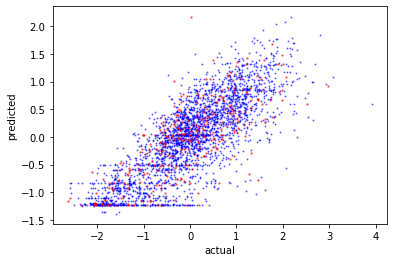

In [7]:
from PredictionUtil import auto_evaluation
y_train_prediction,y_test_prediction=auto_evaluation(model,
                        x_train,y_train.ravel(),x_test,y_test.ravel())

# Analyses
# Control experiment
- Find the top i-th compound in the train dataset
- Compare fingerprints with the test dataset
    - Tanimoto similarity is used for comparison


ave y: 0.28


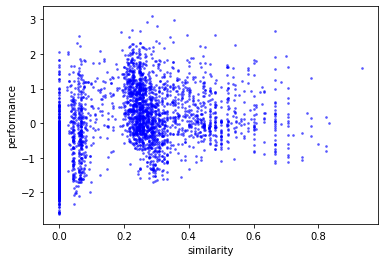

In [8]:
from SimilarFPAnalyzer import SimilarFPAnalyzer
i=1

sim_fp_anal=SimilarFPAnalyzer(target_param_name,smiles_converter)

x_all=np.concatenate([x_train,x_test])
y_all=np.concatenate([y_train,y_test])

actual_best_fingerprint,act_best_bit=sim_fp_anal.explore_actual_best_fingerprint(df,i,smiles_column=smiles_column)
similarity_list,y_all=sim_fp_anal.compare_with_data_base(actual_best_fingerprint,x_all,y_all,percent=5)

# Find best bit by annealer
- Digital annealer is not currently open for public
    - Blueqat can be used instead
    - Global minimum may not be obtained with large dimensions
- After annealing, restore the found bit to the fingerprint form (2048-dim)

In [9]:
#give c_pert if necessary as a restriction condition
from DAWrapper import get_pertubated_coeff

c_pert=0.00
mix_coeff=get_pertubated_coeff(model.coef_,act_best_bit[0],c_pert)


Wall time: 2.09 s


ave y: 0.86
best Y:  5.011657212956029


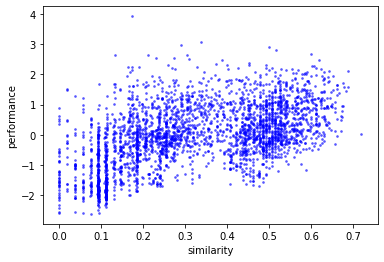

In [10]:
#bluecat annealing
from BlueqatWrapper import auto_bit_search_by_blueqat
from RegressionModelAnalyzer import RegressionModelAnalyzer

#find best val by simulated annealing (this may take a long time)
%time ideal_bit,_=auto_bit_search_by_blueqat(mat=smiles_converter.qubo_utility.calculate_QUBO_matrix(mix_coeff),shots=20)
ideal_fingerprint=smiles_converter.bit_compressor.inverse_transform([ideal_bit])[0]
print("\n")
similarity_list,_=sim_fp_anal.compare_with_data_base(ideal_fingerprint,x_all,y_all,percent=5)

regress_analyzer=RegressionModelAnalyzer(model,smiles_converter)
y=regress_analyzer.predict_from_compound_bit(np.array(ideal_bit).reshape(1,-1))[0]
print("best Y: ",y)

# Find compounds similar to the found bit

C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


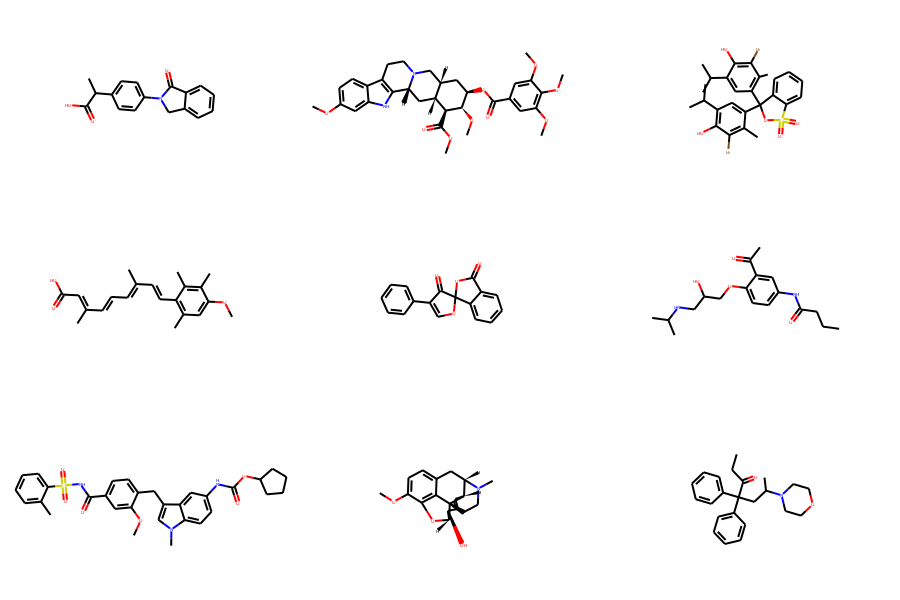

In [11]:
#draw candidate molecules with higher similarity
train_df["Similarity"]=list(similarity_list[:y_train.shape[0]])
s=train_df.sort_values(by="Similarity",ascending=False)
smiles_list=s[smiles_column].values[:9]
mols=[Chem.MolFromSmiles(i) for i in smiles_list]

Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,200))

# Visualize corresponding fragment moieties of found bit

In [12]:
from SMILESFragmentizer import fragmentate_chemicals,generate_chemicals_from_fragments

regress_analyzer.set_ideal_bit([ideal_bit])

#extract important bitIDs from ideal FP
bit_ID_list=regress_analyzer.get_fingerprint_ids()

#fragmentate chemicals
SMILES_list=train_df[smiles_column].values

frag_SMILES_list=fragmentate_chemicals(SMILES_list)
fingerprint_list,_=FP.calc_fingerprint(frag_SMILES_list)
dataset=list(zip(frag_SMILES_list,fingerprint_list))

100%|█████████████████████████████████████████████████████████████████████████████| 2723/2723 [00:06<00:00, 425.81it/s]


In [13]:
from FPVisualizer import FPVisualizer

fp_visualizer=FPVisualizer(dataset)
#img,smiles_list=fp_visualizer.auto_draw_fragments(bit_ID_list)
#print("{} types of fragments. may be too much!".format(len(smiles_list)))

In [14]:
#delete similar fragments
modif_bit_ID_list,_=fp_visualizer.calc_duplicate_array(bit_ID_list,threshold=0.6,plot=False)
print("{} types of fragments".format(len(modif_bit_ID_list)))
img,smiles_list=fp_visualizer.auto_draw_fragments(modif_bit_ID_list,draw=False)
#img

26 types of fragments


In [15]:
#draw original molecules
"""
smiles_list=list(set(smiles_list))
mols=[Chem.MolFromSmiles(i) for i in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,200))
"""

'\nsmiles_list=list(set(smiles_list))\nmols=[Chem.MolFromSmiles(i) for i in smiles_list]\nDraw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,200))\n'

# Reconnect fragments

In [17]:
#randomly make molecules from fragments
#this would take some time. if too long, re-run this cell
smiles_list=generate_chemicals_from_fragments(smiles_list,10)

In [18]:
#predict
gen_x=smiles_converter.transform(smiles_list)
pY=model.predict(gen_x)

rdf=pd.DataFrame()
rdf["SMILES"]=smiles_list
rdf["predictedY"]=pY
rdf=rdf.sort_values(by="predictedY",ascending=False).reset_index()
rdf[:10]

,index,SMILES,predictedY
0,8,NCc1nc(-c2cc(OC=O)ccc2N)[nH]c1C1CO1,1.874215
1,9,NCc1nc(-c2cc(-n3cncn3)ccc2N)[nH]c1C1CO1,1.771961
2,5,NCc1nc(-c2cc(C3CCCCC3)ccc2N)[nH]c1C1CO1,1.624564
3,7,NCc1nc(-c2cc(C3CO3)ccc2N)[nH]c1C1CO1,1.479367
4,6,NCc1nc(-c2cc(C(=O)/C=N/O)ccc2N)[nH]c1C1CO1,1.397258
5,3,c1ncn(C2CO2)n1,-0.127888
6,1,O=C(/C=N/O)C1CO1,-0.182971
7,0,C1CCC(C2CO2)CC1,-0.680290
8,2,NCC1CO1,-0.774732
9,4,O=COC1CO1,-0.976290


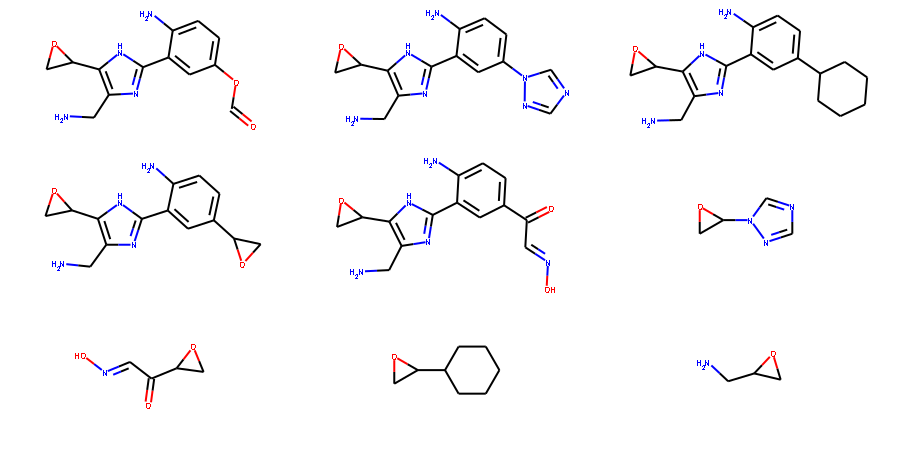

In [19]:
mols = [Chem.MolFromSmiles(f) for f in rdf["SMILES"][:9]]
Draw.MolsToGridImage(mols[:9], molsPerRow=3, subImgSize=(300,150))